In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import warnings as w
import sys
sys.path.append("../../..")
import Thermobar as pt

## Their parameters
- Cpx-only Use mytry of 6, counter to package default, mtry of 1/3 total number of variables. Use ntree of 201
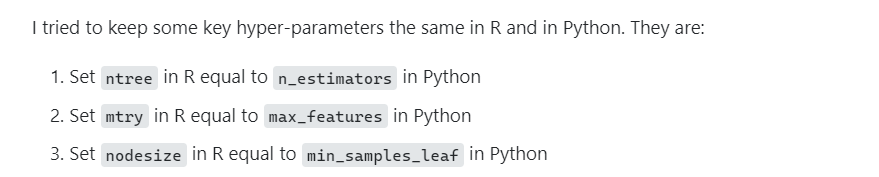
- Cpx-Liq, use mtry of 2/3 of variable. 
- Use 1 cut
- Preprocess the claibration data - use structural formula of Deer et al. 1997. Convert FE2O3 and FeO , go to 100 anhydrous.
- But dont seem to use this?
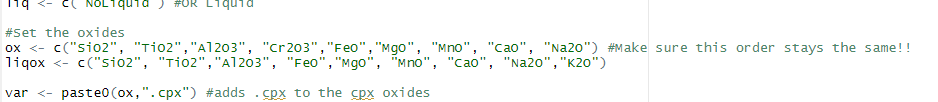

In [2]:
out_train=pt.import_excel('Jorgenson_Input_filtered.xlsx',
                          sheet_name='Jorgenson_Input_filtered_ThBar')
out_train_input=out_train['my_input']
Cpx_train=out_train['Cpxs']
Cpx_train_noID_noT=Cpx_train.drop(['Sample_ID_Cpx'], axis=1)
x_train=Cpx_train_noID_noT.values
y_train_T=out_train_input['T_K']
y_train_P=out_train_input['P_kbar']
Kd_Corin_train=(
    (out_train_input['FeOt_Cpx']/out_train_input['MgO_Cpx'])
/(out_train_input['FeOt_Liq']/out_train_input['MgO_Liq'])
)

In [3]:
# Scaling
#scaler = StandardScaler().fit(x_train)
#x_train_scaled = scaler.transform(x_train)

# Define the regressor, in our case the Extra Tree Regressor
# Using the parameters from Petrelli supplement for P. Don't actually present a regression for T, 
# but we add it here.
regr_T = ExtraTreesRegressor(n_estimators=201, criterion='squared_error', max_features=6, 
                           
                             random_state=120) # random_state fixed for reproducibility

# Define the regressor, in our case the Extra Tree Regressor
regr_P = ExtraTreesRegressor(n_estimators=201, criterion='squared_error', max_features=6, 
                             
                             random_state=120) # random_state fixed for reproducibility

# Train the model
regr_T.fit(x_train, y_train_T.ravel())
regr_P.fit(x_train, y_train_P.ravel())


#x_test_scaled=scaler.transform(x_test)

C:\Users\penny\AppData\Local\Temp\ipykernel_46204\843370081.py:18: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  regr_T.fit(x_train, y_train_T.ravel())
C:\Users\penny\AppData\Local\Temp\ipykernel_46204\843370081.py:19: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  regr_P.fit(x_train, y_train_P.ravel())


ExtraTreesRegressor(max_features=6, n_estimators=201, random_state=120)

In [4]:
import sklearn
print(sklearn.__version__)

1.6.1


In [5]:
## For version 1_3


# from pickle import dump
# dump(scaler, open('scaler_Jorg21_Cpx_only_April24.pkl', 'wb'))


import joblib
joblib.dump(regr_P,  'ETR_Press_Jorg21_Cpx_only_NotNorm_sklearn_1_6_1.pkl',compress=3)

joblib.dump(regr_T,  'ETR_Temp_Jorg21_Cpx_only_NotNorm_sklearn_1_6.pkl',compress=3)

## For versoin 1.6.1, reran on 2nd April 2025



['ETR_Temp_Jorg21_Cpx_only_NotNorm_sklearn_1_6.pkl']

## Testing recalibration looks okay

In [28]:
## New test data
out_test=pt.import_excel('Jorgenson_Input_filtered.xlsx',
                          sheet_name='New_Test_Data')
out_test_input=out_test['my_input']
Cpx_test=out_test['Cpxs']

y_test_T=out_test_input['T_K_x']
y_test_P=out_test_input['P_kbar_x']
Temp_Press_Cpx_only=pt.calculate_cpx_only_press_temp(cpx_comps=Cpx_test, equationT='T_Jorgenson2022_Cpx_only', 
                                               equationP='P_Jorgenson2022_Cpx_only')

Temp_Press_Cpx_only_onnx=pt.calculate_cpx_only_press_temp(cpx_comps=Cpx_test, equationT='T_Jorgenson2022_Cpx_only_onnx', 
                                               equationP='P_Jorgenson2022_Cpx_only_onnx')
Temp_Press_Cpx_only.head()

Youve selected a P-independent function
Youve selected a T-independent function
Youve selected a P-independent function
Youve selected a T-independent function


,P_kbar_calc,T_K_calc,Delta_P_kbar_Iter,Delta_T_K_Iter,Median_Trees_P,Std_Trees_P,IQR_Trees_P,Median_Trees_T,Std_Trees_T,IQR_Trees_T,...,Jd,"Jd_from 0=Na, 1=Al",CaTs,CaTi,DiHd_1996,EnFs,DiHd_2003,Di_Cpx,FeIII_Wang21,FeII_Wang21
0,5.517883,1389.647512,0,0,5.017,3.610622,3.610622,1398.15,76.636970,76.636970,...,0.017209,0,0.069258,0.035247,0.644420,0.256177,0.644420,0.490357,0.047126,0.227519
1,5.675299,1412.363930,0,0,5.017,4.000478,4.000478,1413.15,76.442669,76.442669,...,0.015671,0,0.085265,0.002158,0.601445,0.284644,0.601445,0.458637,-0.014476,0.287000
2,5.920577,1415.169900,0,0,5.020,3.612526,3.612526,1416.15,70.033465,70.033465,...,0.019302,0,0.064096,0.031416,0.591894,0.311878,0.591894,0.452645,0.043418,0.237799
3,4.482134,1408.667413,0,0,2.060,3.556728,3.556728,1425.15,86.769902,86.769902,...,0.017697,0,0.086546,0.003791,0.672498,0.213679,0.672498,0.550286,-0.007247,0.203579
4,6.098015,1356.538060,0,0,7.000,3.442876,3.442876,1333.15,69.075261,69.075261,...,0.021481,0,0.076693,0.049456,0.665250,0.222094,0.665250,0.525538,0.075577,0.152972


0.06183893766461599
RMSE
2.24031
75.86239391278573
RMSE
102.33


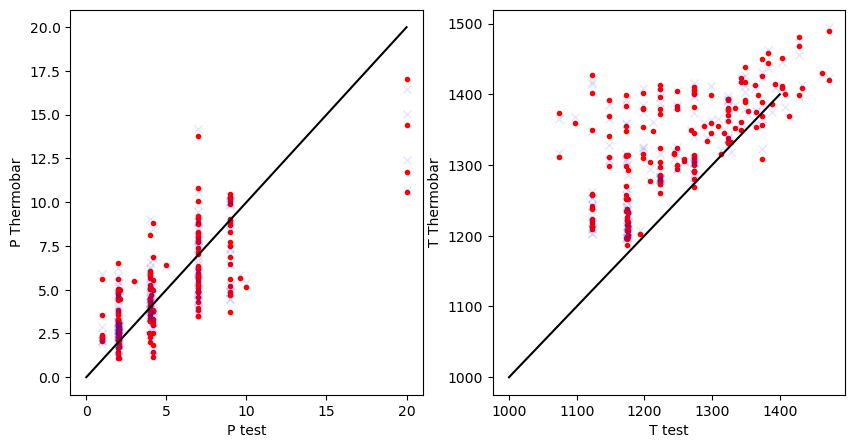

In [30]:
## Testing Cpx-only pressure and temp. 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(y_test_P, Temp_Press_Cpx_only['P_kbar_calc'], '.r' )
ax1.plot(y_test_P, Temp_Press_Cpx_only_onnx['P_kbar_calc'], 'xb', alpha=0.1 )
ax1.set_xlabel('P test')
ax1.set_ylabel('P Thermobar')
ax1.plot([0, 20], [0, 20], '-k')
stats_P=pt.calculate_R2(y_test_P, Temp_Press_Cpx_only['P_kbar_calc'])
print('RMSE')
print(stats_P['RMSE_num'])

ax2.plot(y_test_T, Temp_Press_Cpx_only['T_K_calc'], '.r' )
ax2.set_xlabel('T test')
ax2.set_ylabel('T Thermobar')
ax2.plot([1000, 1400], [1000, 1400], '-k')
stats_T=pt.calculate_R2(y_test_T, Temp_Press_Cpx_only['T_K_calc'])
ax2.plot(y_test_T, Temp_Press_Cpx_only_onnx['T_K_calc'], 'xb', alpha=0.1 )
print('RMSE')
print(stats_T['RMSE'])

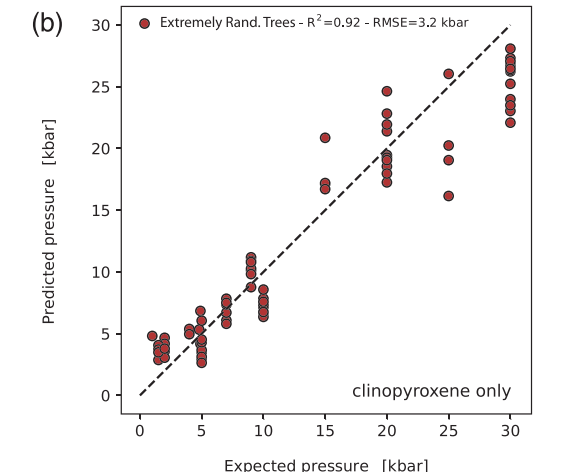